<a href="https://colab.research.google.com/github/juniorsantin1992/projeto_analise_loggy/blob/main/projeto_analise_loggy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análise Exploratória de Dados de Logística - Empresa Loggy**

# 1\. Contexto

A Loggi é uma startup brasileira de tecnologia especializada em logística. Começou em 2013 entregando documentos, expandindo para e-commerce em 2016 e, desde 2017, atua também na entrega de alimentos. Assim como outras empresas do setor, a Loggi enfrenta desafios em áreas metropolitanas, onde a distribuição de entregas é desigual e a geografia complexa das cidades adiciona dificuldades.

Os dados desta análise vêm do repositório Loggi Benchmark for Urban Deliveries (BUD), que inclui conjuntos de dados e scripts de benchmark para problemas logísticos típicos, como a otimização de rotas e a alocação de entregas em veículos com capacidade limitada. Esses dados, sintetizados de fontes públicas (IBGE, IPEA, etc.), refletem os desafios enfrentados pela Loggi, especialmente em termos de escala.

Na presente análise, meu objetivo é investigar as questões de logística enfrentadas pelos hubs regionais da Loggi, utilizando os dados disponibilizados da região de Brasília. Pretendo obter insights valiosos sobre as rotas de entrega atuais e sugerir soluções para torná-las mais eficientes e ágeis. Ao explorar os dados logísticos, busco entender como os desafios enfrentados impactam a eficiência das entregas e encontrar maneiras práticas de melhorá-las, contribuindo assim para a otimização das operações de entrega da Loggi.

Este estudo não apenas aborda os problemas atuais de logística, mas também propõe uma abordagem prática para melhorar a eficiência dos hubs de distribuição e equilibrar a carga de trabalho entre eles. Com base nos dados analisados, espero fornecer recomendações detalhadas e viáveis que possam ser implementadas para aprimorar as operações logísticas da Loggi em Brasília e, potencialmente, em outras regiões atendidas pela empresa.
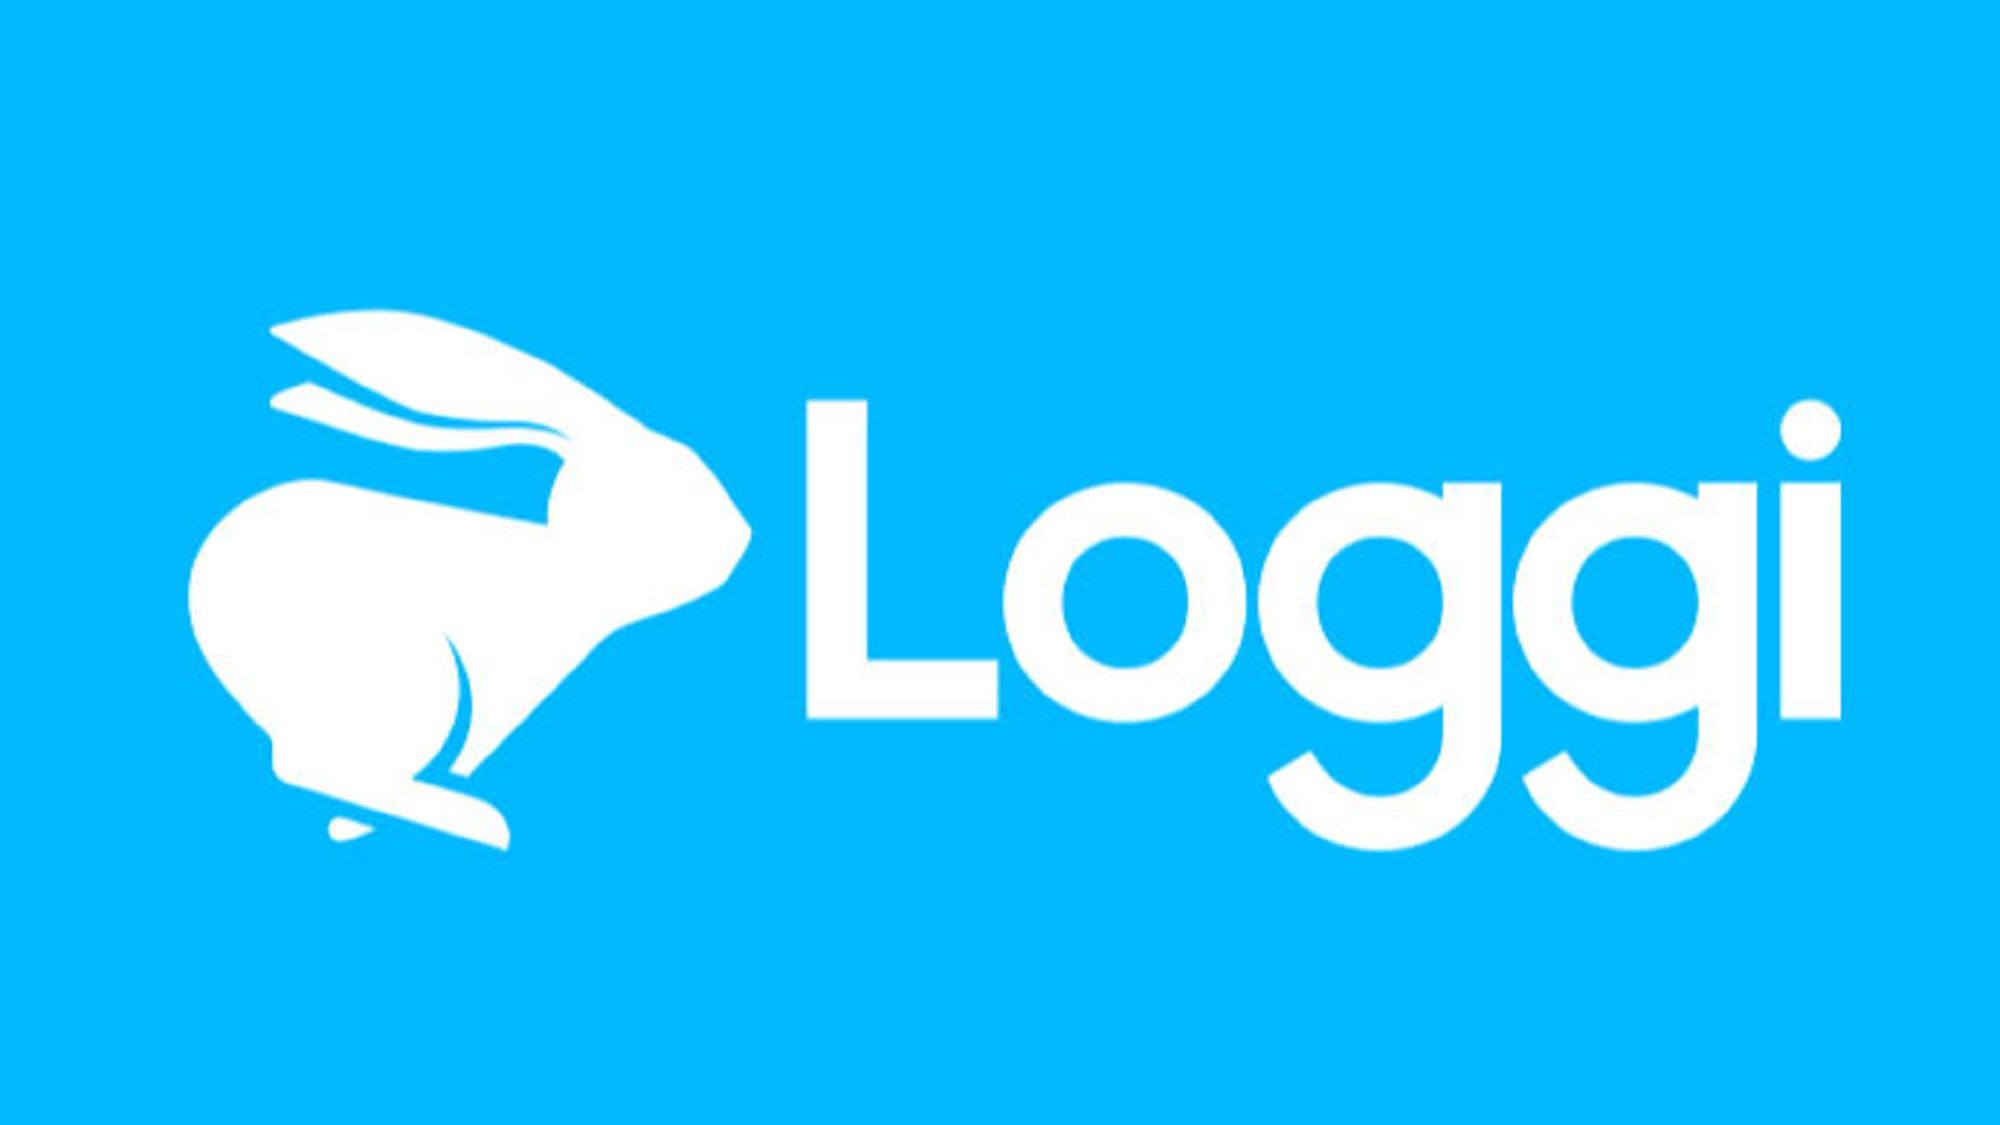

# **2. Pacotes e bibliotecas**

In [ ]:
# Instalando e importando todas as bibliotecas utilizadas no projeto
!pip3 install geopandas
!pip install tabula-py PyPDF2

import json

import tabula
import PyPDF2
from PyPDF2 import PdfReader
import pandas as pd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 16.9 MB/s eta 0:00:00


## 3\. Exploração de dados

### 3\.1 Coleta dos dados

In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json

In [ ]:
# Extraindo as informações de entregas de um arquivo json e carregando em um dict python
with open('deliveries.json', mode='r', encoding='utf8') as file:
  data = json.load(file)

# Transformando o dict python em um DataFrame do pandas
deliveries_df = pd.DataFrame(data)

# Visualizando o DataFrame deliveries_df
deliveries_df.head()

,name,region,origin,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...",180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...",180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


### 3\.2 Data Wrangling
Na coluna origin contem dados aninhados na estrutura do JSON. Vamos normalizar a coluna com uma operação conhecida como flatten ou achatamento que transforma cada chave do JSON em uma nova coluna:

In [ ]:
# Normalizando a coluna origin (gera um novo dataframe com as informações da coluna "origin" separadas em colunas)
hub_origin_df = pd.json_normalize(deliveries_df["origin"])
hub_origin_df

,lng,lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145
...,...,...
194,-47.893662,-15.805118
195,-47.802665,-15.657014
196,-47.893662,-15.805118
197,-48.054989,-15.838145


Com o novo DataFrame gerado, podemos mesclar ao DataFrame original pelo index e então excluir a coluna "origin" original.

In [ ]:
# Mesclando os DataFrames com o método merge do pandas por um inner join através dos index
deliveries_df = pd.merge(left=deliveries_df, right=hub_origin_df, how='inner', left_index=True, right_index=True)

# Excluindo a coluna "origin" original utilizando o Drop
deliveries_df = deliveries_df.drop("origin", axis=1)

# Selecionando e renomeando as novas colunas do DataFrame
deliveries_df = deliveries_df[["name", "region", "lng", "lat", "vehicle_capacity", "deliveries"]]
deliveries_df.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)
deliveries_df

,name,region,hub_lng,hub_lat,vehicle_capacity,deliveries
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,"[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,-48.054989,-15.838145,180,"[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,-48.054989,-15.838145,180,"[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,-47.893662,-15.805118,180,"[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,-48.054989,-15.838145,180,"[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."
...,...,...,...,...,...,...
194,cvrp-1-df-59,df-1,-47.893662,-15.805118,180,"[{'id': 'fc800db1942651f8195f870c5930ca26', 'p..."
195,cvrp-0-df-87,df-0,-47.802665,-15.657014,180,"[{'id': '3d50e820e1c16621e1fa19f1a7df0c56', 'p..."
196,cvrp-1-df-83,df-1,-47.893662,-15.805118,180,"[{'id': 'e6cffd090ce2a7bd0e0292f1ed9acd3', 'po..."
197,cvrp-2-df-7,df-2,-48.054989,-15.838145,180,"[{'id': '51b1354b02a20d919b83bb664ea4d845', 'p..."


Na coluna deliveries contem uma lista de dados nested ou aninhados na estrutura do JSON. Vamos normalizar a coluna com uma operação conhecida como explode ou explosão que transforma cada elemento da lista em uma linha. Por fim, faremos os flatten ou achatamento do resultado coluna:

In [ ]:
deliveries_exploded_df = deliveries_df[["deliveries"]].explode("deliveries")
deliveries_exploded_df.head()

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."


In [ ]:
deliveries_normalized_df = pd.concat([
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(deliveries_exploded_df["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)
deliveries_normalized_df.head()

,delivery_size,delivery_lng,delivery_lat
0,9,-48.116189,-15.848929
0,2,-48.118195,-15.850772
0,1,-48.112483,-15.847871
0,2,-48.118023,-15.846471
0,7,-48.114898,-15.858055


Com o dados explodidos, vamos normaliza-los para combina-los ao conjunto de dados principal:

In [ ]:
# Excluindo a coluna "deliveries" original
deliveries_df = deliveries_df.drop("deliveries", axis=1)

# Mesclando o novo DataFrame deliveries_normalized_df com o DataFrame original deliveries_df, right join pelo index
deliveries_df = pd.merge(left=deliveries_df, right=deliveries_normalized_df, how='right', left_index=True, right_index=True)
deliveries_df.reset_index(inplace=True, drop=True)

deliveries_df

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055
...,...,...,...,...,...,...,...,...
636144,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,8,-48.064269,-15.997694
636145,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,4,-48.065176,-16.003597
636146,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,9,-48.065841,-16.003808
636147,cvrp-2-df-62,df-2,-48.054989,-15.838145,180,1,-48.062327,-16.001568


###3\.3 Análise Exploratória

Agora, com os dados estruturados em um DataFrame devidamente, partiremos para análise exploratória e limpeza dos dados.

In [ ]:
# Ver as dimensões do DF
deliveries_df.shape

(636149, 8)

In [ ]:
# Conhecer os tipos de dados e as colunas.
deliveries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              636149 non-null  object 
 1   region            636149 non-null  object 
 2   hub_lng           636149 non-null  float64
 3   hub_lat           636149 non-null  float64
 4   vehicle_capacity  636149 non-null  int64  
 5   delivery_size     636149 non-null  int64  
 6   delivery_lng      636149 non-null  float64
 7   delivery_lat      636149 non-null  float64
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


In [ ]:
# Identificar valores nulos
deliveries_df.isna().sum()

name                0
region              0
hub_lng             0
hub_lat             0
vehicle_capacity    0
delivery_size       0
delivery_lng        0
delivery_lat        0
dtype: int64

In [ ]:
# Contar valores distintos nas colunas.
deliveries_df.nunique()

name                   199
region                   3
hub_lng                  3
hub_lat                  3
vehicle_capacity         1
delivery_size           10
delivery_lng        291566
delivery_lat        291566
dtype: int64

In [ ]:
# Separar os dados numéricos dos dados categóricos
var_numericos = []
var_categoricas = []

for coluna in deliveries_df.columns:
  if deliveries_df[coluna].dtype != "object":
    var_numericos.append(coluna)
  else:
    var_categoricas.append(coluna)

print(f'As colunas numéricas são: {var_numericos}')
print(f'As colunas categóricas são: {var_categoricas}')

As colunas numéricas são: ['hub_lng', 'hub_lat', 'vehicle_capacity', 'delivery_size', 'delivery_lng', 'delivery_lat']
As colunas categóricas são: ['name', 'region']


In [ ]:
# Ver um resumo estatístico dos dados numéricos.
deliveries_df[var_numericos].describe().T

,count,mean,std,min,25%,50%,75%,max
hub_lng,636149.0,-47.949902,0.091875,-48.054989,-48.054989,-47.893662,-47.893662,-47.802665
hub_lat,636149.0,-15.802359,0.053463,-15.838145,-15.838145,-15.805118,-15.805118,-15.657014
vehicle_capacity,636149.0,180.000000,0.000000,180.000000,180.000000,180.000000,180.000000,180.000000
delivery_size,636149.0,5.512111,2.874557,1.000000,3.000000,6.000000,8.000000,10.000000
delivery_lng,636149.0,-47.946087,0.112769,-48.280779,-48.035911,-47.928967,-47.883394,-47.310611
delivery_lat,636149.0,-15.809492,0.082462,-16.050028,-15.842795,-15.814033,-15.769516,-15.500355


Observação 1: Observa-se que os dados da coluna "vehicle_capacity" não apresentam variação, todos os valores são iguais a "180". Observação 2: Os valores da coluna "delivery_size" mostram que os volumes variam moderadamente, com uma média de 5.5121 e uma mediana de 6.0000, logo, desvio padrão de 2.8746, considerando a baixa amplitude, são variações relativamente moderadas.

In [ ]:
# Ver um resumo dos dados categóricos.
deliveries_df[var_categoricas].describe().T

,count,unique,top,freq
name,636149,199,cvrp-1-df-87,5636
region,636149,3,df-1,304708


Observação 3: há 3 regiões principais dos HUB's, e a região que mais está relacionada a entregas é a região df-1 com 304708 registros.

#4 Manipulação dos dados


In [ ]:
!wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
!unzip -q distrito-federal.zip -d ./maps
!cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
!cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx

In [ ]:
# Implementando o DataFrame de Área dos distritos do DF com Geopandas e arquivo .shp

mapa_df = gpd.read_file("distrito-federal.shp")
mapa_df = mapa_df.loc[[0]]
if mapa_df.crs is None:
    mapa_df.crs = 'EPSG:4326'
mapa_df = mapa_df.to_crs(epsg=32723)
mapa_df['Area(km)'] = mapa_df.area / 10**6
mapa_df = pd.DataFrame(mapa_df)
mapa_df

,geometry,Area(km)
0,"POLYGON Z ((252785.743 8225703.192 0.000, 2527...",5784.571009


In [ ]:
!pip install geopandas
import geopandas

mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


Vamos criar o DataFrame geo_hub_df através do DataFrame deliveries_df. Note a nova coluna geometry.

In [ ]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


Vamos criar o DataFrame geo_deliveries_df através do DataFrame deliveries_df. Note a nova coluna geometry.

In [ ]:
geo_deliveries_df = geopandas.GeoDataFrame(deliveries_df, geometry=geopandas.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,9,-48.116189,-15.848929,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118195,-15.850772,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,1,-48.112483,-15.847871,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,2,-48.118023,-15.846471,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,180,7,-48.114898,-15.858055,POINT (-48.11490 -15.85805)


In [ ]:
import json

import geopy
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="ebac_geocoder")
location = geolocator.reverse("-15.657013854445248, -47.802664728268745")

In [ ]:
from geopy.extra.rate_limiter import RateLimiter

geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

In [ ]:
hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."


In [ ]:
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))
hub_geodata_df.head()

,place_id,licence,osm_type,osm_id,lat,lon,class,type,place_rank,importance,...,address.state,address.ISO3166-2-lvl4,address.region,address.postcode,address.country,address.country_code,address.neighbourhood,address.suburb,address.residential,address.town
0,43777060,"Data © OpenStreetMap contributors, ODbL 1.0. h...",node,6249717596,-15.8384371,-48.0552917,shop,pastry,30,0.000010,...,Distrito Federal,BR-DF,Região Centro-Oeste,72015-030,Brasil,br,NaN,NaN,NaN,NaN
1,46401425,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,66353368,-15.805172753950067,-47.89372354453109,highway,residential,26,0.053411,...,Distrito Federal,BR-DF,Região Centro-Oeste,70336-000,Brasil,br,SQS 303,Asa Sul,NaN,NaN
2,46410411,"Data © OpenStreetMap contributors, ODbL 1.0. h...",way,240210480,-15.656916027876347,-47.80264463632131,highway,secondary,26,0.053343,...,Distrito Federal,BR-DF,Região Centro-Oeste,73015-127,Brasil,br,NaN,Sobradinho,Quadra 2,Sobradinho


In [ ]:
import numpy as np

hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

<ipython-input-25-d83d9be41f84>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
<ipython-input-25-d83d9be41f84>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])


,hub_suburb,hub_city
0,Taguatinga,Taguatinga
1,Asa Sul,Brasília
2,Sobradinho,Sobradinho


In [ ]:
#O DataFrame hub_geodata_df com as informações de cidade e bairro é então combinado ao DataFrame principal deliveries_df, enriquecendo assim o dado.
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-2,Taguatinga,Taguatinga
1,df-1,Asa Sul,Brasília
2,df-0,Sobradinho,Sobradinho


In [ ]:
deliveries_df = pd.merge(left=deliveries_df, right=hub_df, how="inner", on="region")
deliveries_df = deliveries_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "vehicle_capacity", "delivery_size", "delivery_lng", "delivery_lat"]]
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055


In [ ]:
!wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv

In [ ]:
deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [ ]:

deliveries_df = deliveries_df.rename(columns={
    'delivery_city_x': 'delivery_city',
    'delivery_suburb_x': 'delivery_suburb'
})


deliveries_df = pd.merge(left=deliveries_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


In [ ]:
mapa = gpd.read_file("distrito-federal.shp")
if mapa.crs is None:
    mapa.crs = 'EPSG:4326'
mapa = mapa.to_crs(epsg=4326)
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [ ]:
!pip install geopandas
import geopandas as gpd
import os

# Set the SHAPE_RESTORE_SHX config option to YES
os.environ['SHAPE_RESTORE_SHX'] = 'YES'

# Now try reading the file
area_adm = gpd.read_file("bairros-df.shp")
area_adm.crs = 'EPSG:32723'
area_adm = area_adm.to_crs(epsg=4326)

area_adm = pd.DataFrame(area_adm).reset_index()
area_adm["index"] = area_adm["index"]+1
area_adm = area_adm.rename(columns={"index":"id"})
area_adm

,id,geometry
0,1,"POLYGON ((-47.85950 -15.68823, -47.85951 -15.6..."
1,2,"POLYGON ((-48.03822 -15.94543, -48.03714 -15.9..."
2,3,"POLYGON ((-48.20825 -15.74034, -48.20778 -15.7..."
3,4,"POLYGON ((-47.76379 -15.52734, -47.76379 -15.5..."
4,5,"POLYGON ((-47.41841 -15.50182, -47.41841 -15.5..."
5,6,"POLYGON ((-47.66188 -15.73406, -47.66217 -15.7..."
6,7,"POLYGON ((-47.95455 -15.84839, -47.95465 -15.8..."
7,8,"POLYGON ((-47.97051 -15.80634, -47.97056 -15.8..."
8,9,"POLYGON ((-47.93818 -15.80552, -47.93963 -15.8..."
9,10,"POLYGON ((-48.04743 -15.85948, -48.04742 -15.8..."


In [ ]:
dRA = pd.read_excel("dimRA.xlsx")
dRA = dRA[["id","RA","Pop 2015", "TMGCA (%)","AU (ha)","AT (ha)","DU 2015 (hab./ha)"]].rename(columns={"Pop 2015":"Pop","TMGCA (%)":"Var %","DU 2015 (hab./ha)":"DU"})
dRA

,id,RA,Pop,Var %,AU (ha),AT (ha),DU
0,23,Varjão,8453,-4.62,59.42,75.56,142.27
1,19,Candangolândia,15641,-3.76,113.85,662.70,137.38
2,9,Ceilândia,479713,3.03,3691.92,23401.14,129.94
3,15,Recanto das Emas,146906,2.81,1246.27,10261.11,117.88
4,14,São Sebastião,99525,0.31,882.69,35571.37,112.75
5,25,SCIA/Estrutural,38429,4.64,350.21,741.75,109.73
6,22,Sudoeste/Octogonal,52990,0.68,505.80,585.61,104.77
7,12,Samambaia,258457,6.39,2501.67,10125.85,103.31
8,11,Cruzeiro,29535,-4.20,290.60,323.05,101.63
9,4,Brazlândia,51816,0.68,554.03,47684.84,93.52


In [ ]:
dimRA = pd.merge(left=area_adm, right=dRA, how="inner", on="id")
dimRA

,id,geometry,RA,Pop,Var %,AU (ha),AT (ha),DU
0,1,"POLYGON ((-47.85950 -15.68823, -47.85951 -15.6...",Plano Piloto,210067,-1.49,10176.75,40989.31,20.64
1,2,"POLYGON ((-48.03822 -15.94543, -48.03714 -15.9...",Gama,134111,-0.31,2631.71,27559.42,50.96
2,3,"POLYGON ((-48.20825 -15.74034, -48.20778 -15.7...",Taguatinga,207045,-1.38,2572.11,8056.15,80.50
3,4,"POLYGON ((-47.76379 -15.52734, -47.76379 -15.5...",Brazlândia,51816,0.68,554.03,47684.84,93.52
4,5,"POLYGON ((-47.41841 -15.50182, -47.41841 -15.5...",Sobradinho,62763,-0.75,1503.93,20122.20,41.73
5,6,"POLYGON ((-47.66188 -15.73406, -47.66217 -15.7...",Planaltina,190495,1.37,2989.46,153847.95,63.72
6,7,"POLYGON ((-47.95455 -15.84839, -47.95465 -15.8...",Paranoá,44975,-1.37,487.46,78876.96,92.26
7,8,"POLYGON ((-47.97051 -15.80634, -47.97056 -15.8...",Núcleo Bandeirante,23562,-0.32,299.77,466.94,78.60
8,9,"POLYGON ((-47.93818 -15.80552, -47.93963 -15.8...",Ceilândia,479713,3.03,3691.92,23401.14,129.94
9,10,"POLYGON ((-48.04743 -15.85948, -48.04742 -15.8...",Guará,133171,5.38,1810.57,2562.92,73.55


#5 Visualização

In [ ]:
hub_df = deliveries_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = gpd.GeoDataFrame(hub_df, geometry=gpd.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
if geo_hub_df.crs is None:
    geo_hub_df.crs = 'EPSG:4326'
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [ ]:
geo_deliveries_df = gpd.GeoDataFrame(deliveries_df, geometry=gpd.points_from_xy(deliveries_df["delivery_lng"], deliveries_df["delivery_lat"]))
if geo_deliveries_df.crs is None:
    geo_deliveries_df.crs = 'EPSG:4326'
geo_deliveries_df = geo_deliveries_df.to_crs(epsg=4326)
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,vehicle_capacity,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,180,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


In [ ]:
mapa = gpd.read_file("distrito-federal.shp")
if mapa.crs is None:
    mapa.crs = 'EPSG:4326'
mapa = mapa.to_crs(epsg=4326)
mapa = mapa.loc[[0]]
mapa.head()

,geometry
0,"POLYGON Z ((-47.31048 -16.03602 0.00000, -47.3..."


In [ ]:
geo_ra_df = gpd.read_file("bairros-df.shx")
geo_ra_df.crs = 'EPSG:32723'
geo_ra_df = geo_ra_df.to_crs(epsg=4326)  # Reprojeta o GeoDataFrame das RAs para a mesma projeção do mapa
geo_ra_df.index = geo_ra_df.index+1
geo_ra_df.head()

,geometry
1,"POLYGON ((-47.85950 -15.68823, -47.85951 -15.6..."
2,"POLYGON ((-48.03822 -15.94543, -48.03714 -15.9..."
3,"POLYGON ((-48.20825 -15.74034, -48.20778 -15.7..."
4,"POLYGON ((-47.76379 -15.52734, -47.76379 -15.5..."
5,"POLYGON ((-47.41841 -15.50182, -47.41841 -15.5..."


In [ ]:
crs_referencia = 'EPSG:4326'

# Reprojete todos os GeoDataFrames para a escala de referência
mapa = mapa.to_crs(crs_referencia)
geo_ra_df = geo_ra_df.to_crs(crs_referencia)
geo_deliveries_df = geo_deliveries_df.to_crs(crs_referencia)
geo_hub_df = geo_hub_df.to_crs(crs_referencia)

 - **Insights**: As entregas estão corretamente alocadas aos seus respectivos hubs;
Os hubs das regiões 0 e 2 fazem entregas em locais distantes do centro e entre si, o que pode gerar um tempo e preço de entrega maior.

<ipython-input-43-11cfa223d232>:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle in lgnd.legendHandles:
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


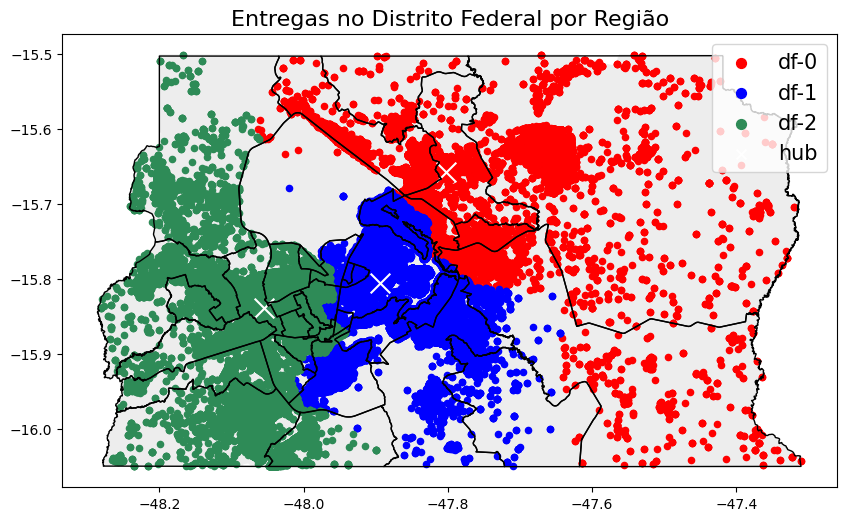

In [ ]:
# cria o plot vazio
fig, ax = plt.subplots(figsize=(10, 10))  # Ajuste o tamanho conforme necessário

# plot mapa do distrito federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=20, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=20, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=20, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=200, marker="x", color="white", label="hub")

# # plot das delimitações das RA's
geo_ra_df.boundary.plot(ax=ax, color="black", linewidth=1)

# plot da legenda
plt.title("Entregas no Distrito Federal por Região", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legendHandles:
    handle.set_sizes([50])

plt.show()

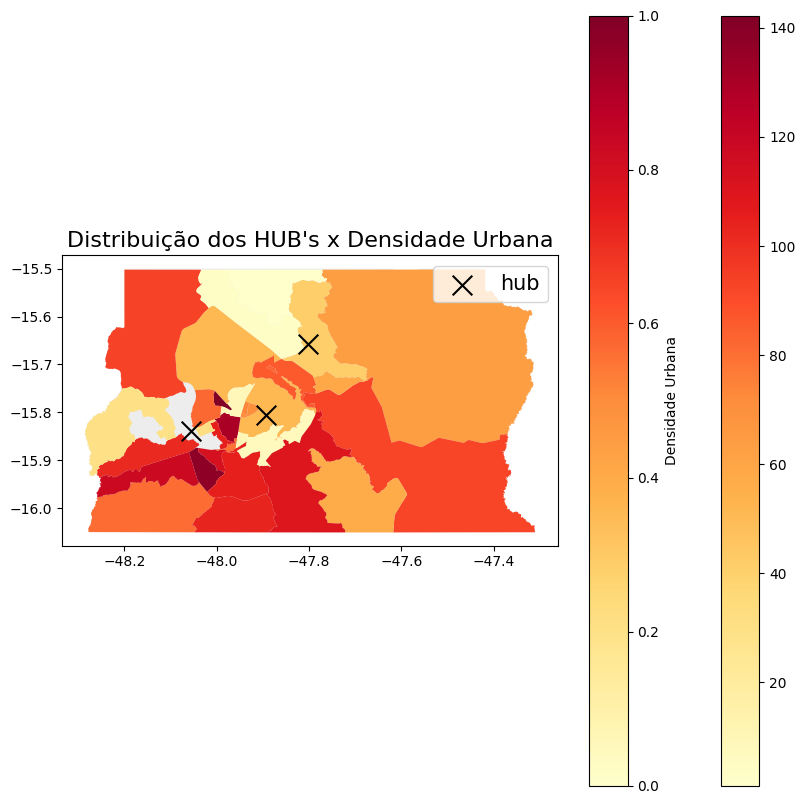

In [ ]:
# cria o plot vazio
fig, ax = plt.subplots(figsize=(10, 10))

# plot mapa do Distrito Federal
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das delimitações das RA's com cores baseadas na densidade demográfica
geo_ra_df['color'] = dimRA['DU']  # Crie uma nova coluna 'color' com os valores de densidade demográfica
geo_ra_df.plot(column='color', cmap='YlOrRd', legend=True, ax=ax, linewidth=1)

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=200, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Distribuição dos HUB's x Densidade Urbana", fontdict={"fontsize": 16})

# Adicione a legenda
legenda = plt.legend(prop={"size": 15})

# Ajuste a legenda para a escala de cores
sm = plt.cm.ScalarMappable(cmap='YlOrRd')
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Densidade Urbana")

plt.show()

conforme o gráfico de Densidade Urbana, nitidamente observa-mos que os Hub's df01 e df02 estão localizados nas regiões com maior densidade urbana, porem o Hub df01 poderia estar localizado mais ao sul para ter uma melhor distribuição não deixando os HUB's tão centralizados.

In [ ]:
data = pd.DataFrame(deliveries_df[['region', 'vehicle_capacity']].value_counts(normalize=True)).reset_index()
data.rename(columns={0: "region_percent"}, inplace=True)
data.head()

,region,vehicle_capacity,proportion
0,df-1,180,0.478988
1,df-2,180,0.410783
2,df-0,180,0.110229


<ipython-input-44-54dbfc8843c8>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  grafico = sns.barplot(data=data, x="region", y="region_percent", palette="pastel")


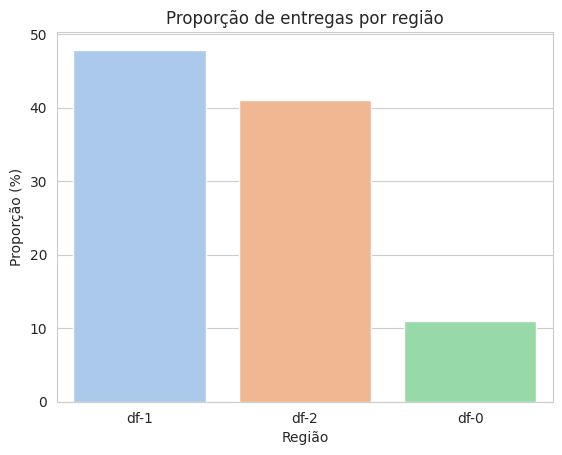

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular a proporção de entregas por região
data = deliveries_df['region'].value_counts(normalize=True).reset_index()
data.columns = ['region', 'region_percent']
data['region_percent'] *= 100  # Converte para porcentagem

with sns.axes_style('whitegrid'):
    grafico = sns.barplot(data=data, x="region", y="region_percent", palette="pastel")
    grafico.set(title='Proporção de entregas por região', xlabel='Região', ylabel='Proporção (%)')

plt.show()

A distribuição das entregas está muito concentrada nos hubs das regiões 1 e 2, mas pouco no da região 0. Contudo a capacidade dos veículos é mesma para todos os hubs, logo os veículos poderiam ser deslocados para as regiões de maior tráfego.

#6 Insights


-   Região df1 (Central de Brasília): A região df1, situada no centro de Brasília,
 é altamente densa e concentrada, com um hub localizado na Asa Sul que também atende as regiões do Lago Norte e Lago Sul. A alta densidade nesta área implica em menor distância entre as entregas, tornando o processo mais eficiente em termos de tempo e custo.


-   Região df0 (Taguatinga, Ceilândia e Zona Rural): em contra partida a região df0, que abrange Taguatinga, Ceilândia e a zona rural de Brasília, é menos concentrada, com entregas mais remotas. Isso aumenta as distâncias entre as entregas, elevando o tempo e os custos logísticos.


-   Região df2 (Sul, Recanto das Emas): A região df2, localizada ao sul apresenta uma característica híbrida: alta concentração em áreas pequenas e pontos de entrega espalhados. A proximidade com Goiás sugere a necessidade de atenção especial às entregas interestaduais, devido aos diferentes regulamentos e distâncias maiores.

-   Localização dos Hubs
A localização dos hubs, em geral, está bem posicionada, com resalva do HUB df01 que poderia estar localizado mais ao sul de brasilia, sendo assim, não ficando tão centralizados em apenas um lugar.

-  Todos os veículos possuem a mesma capacidade de carga, o que pode não ser o melhor para as regiões que possuem entregas mais remotas por conta do pouco volume de carga acarretando em um custo maior, uma proposta para estudo seria de diminuir a quantidade de veiculos do Hub df0 e deslocar para as regiões mais com maior densidade urbana e trocar a frota para caminhões ou veiculos que tenha mais capacidade de carga para longas viajens, otimizando a entrega e o custo envolvido.



#6.1 Propostas de Melhorias
- Otimização de Rotas
Região df1: Para a otimização de rotas na região df1, é recomendável utilizar algoritmos de otimização, como o algoritmo de Clarke-Wright. Esse algoritmo ajuda a minimizar a distância total percorrida e o tempo das entregas, aproveitando a alta densidade da região para consolidar rotas de maneira eficiente.


 - Região df0: Na região df0, onde as entregas são mais dispersas, seria benéfico implementar roteirização dinâmica que ajuste as rotas em tempo real, considerando o tráfego e as condições das estradas. Além disso, a utilização de pontos de parada intermediários pode ajudar a reduzir a distância entre as entregas, otimizando o tempo de entrega.


- Região df2: Na região df2, uma combinação de roteirização fixa para áreas densas e roteirização dinâmica para pontos espalhados pode ser mais eficiente. É crucial considerar rotas interestaduais eficientes, especialmente para as áreas próximas a Goiás, para garantir entregas oportunas e econômicas.
Alocação de Entregas e Veículos


- Revisar a capacidade dos veículos é essencial. Veículos menores podem ser alocados para áreas de alta densidade, como a região df1, para garantir que possam navegar mais facilmente em áreas congestionadas e realizar mais entregas em menos tempo. Para áreas mais dispersas, como as regiões df0 e df2, veículos maiores ou com maior autonomia são mais adequados, pois podem transportar mais mercadorias em uma única viagem, reduzindo o número de viagens necessárias e, consequentemente, os custos.



- Realizar uma análise geoespacial detalhada para identificar possíveis reposicionamentos dos hubs, especialmente nas regiões fronteiriças. Isso pode incluir a criação de sub-hubs ou pontos de consolidação temporários para melhorar a cobertura e eficiência.